In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow


In [ ]:
!pip install ImageHash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 64.9 MB/s eta 0:00:00


In [53]:
import os
from PIL import Image
import secrets
import random
import time
import matplotlib.pyplot as plt
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.fernet import Fernet
import base64
import cv2
from skimage.metrics import structural_similarity as ssim
import imagehash

In [ ]:

def text_to_bin(text):
    binary = ''.join([format(ord(i), '08b') for i in text])
    return binary
def bin_to_text(binary):
    chars = [chr(int(binary[i:i+8], 2)) for i in range(0, len(binary), 8)]
    return ''.join(chars)
def encode_image(image_path, secret_message, output_path):
    image = Image.open(image_path)
    image = image.convert("RGB")
    pixels = image.load()
    binary_secret_message = text_to_bin(secret_message) + '1111111111111110'
    data_index = 0
    for row in range(image.size[1]):
        for col in range(image.size[0]):
            if data_index < len(binary_secret_message):
                r, g, b = pixels[col, row]
                r = (r & ~1) | int(binary_secret_message[data_index])
                pixels[col, row] = (r, g, b)
                data_index += 1
    image.save(output_path)
    print(f"Message hidden in {output_path}")
def decode_image(image_path):
    image = Image.open(image_path)
    pixels = image.load()
    binary_message = ""
    for row in range(image.size[1]):
        for col in range(image.size[0]):
            r, g, b = pixels[col, row]
            binary_message += str(r & 1)
    end_signal = '1111111111111110'
    if end_signal in binary_message:
        binary_message = binary_message[:binary_message.index(end_signal)]
    return bin_to_text(binary_message)
# input_image_path = "input_image.jpeg"
# output_image_path = "encoded_image.png"
# secret_message = "This is a secret!"
# encode_image(input_image_path, secret_message, output_image_path)
# decoded_message = decode_image(output_image_path)
# print("Decoded message:", decoded_message)


LSB-2 -> Change least 2 significant bits of the pixel value

In [ ]:
def text_to_bin(text):
    binary = ''.join([format(ord(i), '08b') for i in text])
    return binary
def bin_to_text(binary):
    chars = [chr(int(binary[i:i+8], 2)) for i in range(0, len(binary), 8)]
    return ''.join(chars)
def encode_image_lsb2(image_path, secret_message, output_path):
    image = Image.open(image_path)
    image = image.convert("RGB")
    pixels = image.load()
    binary_secret_message = text_to_bin(secret_message) + '1111111111111110'
    binary_secret_message = [binary_secret_message[i:i+2] for i in range(0, len(binary_secret_message), 2)]

    data_index = 0
    for row in range(image.size[1]):
        for col in range(image.size[0]):
            if data_index < len(binary_secret_message):
                r, g, b = pixels[col, row]
                r = (r & ~3) | int(binary_secret_message[data_index], 2)
                pixels[col, row] = (r, g, b)

                data_index += 1
    image.save(output_path)
    print(f"Message hidden in {output_path}")
def decode_image_lsb2(image_path):
    image = Image.open(image_path)
    pixels = image.load()
    binary_message = ""
    for row in range(image.size[1]):
        for col in range(image.size[0]):
            r, g, b = pixels[col, row]
            binary_message += format(r & 3, '02b')
    end_signal = '1111111111111110'
    if end_signal in binary_message:
        binary_message = binary_message[:binary_message.index(end_signal)]

    return bin_to_text(binary_message)
# input_image_path = "images.png"
# output_image_path = "encoded_image_lsb2_2.png"
# secret_message = "This is a secret!"
# encode_image_lsb2(input_image_path, secret_message, output_image_path)
# decoded_message = decode_image_lsb2(output_image_path)
# print("Decoded message:", decoded_message)


In [ ]:
def derive_key_from_password(password, salt):
    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA512(),
        length=32,
        salt=salt,
        iterations=100000,
        backend=default_backend()
    )
    return base64.urlsafe_b64encode(kdf.derive(password.encode()))
def encrypt_message(message, password):
    salt = os.urandom(16)
    key = derive_key_from_password(password, salt)
    cipher_suite = Fernet(key)
    encrypted_message = cipher_suite.encrypt(message.encode())
    encrypted_with_salt = salt + encrypted_message
    return base64.urlsafe_b64encode(encrypted_with_salt).decode()
def decrypt_message(encrypted_data, password):
    encrypted_with_salt = base64.urlsafe_b64decode(encrypted_data.encode())
    salt = encrypted_with_salt[:16]
    encrypted_message = encrypted_with_salt[16:]
    key = derive_key_from_password(password, salt)
    cipher_suite = Fernet(key)
    decrypted_message = cipher_suite.decrypt(encrypted_message).decode()
    return decrypted_message
user_input_key = input("Enter the encryption key (password): ")
message = input("Enter the message to encrypt: ")
encrypted_message = encrypt_message(message, user_input_key)
print("\nEncrypted message:", encrypted_message)
user_input_key_for_decryption = input("\nEnter the same key to decrypt the message: ")
try:
    decrypted_message = decrypt_message(encrypted_message, user_input_key_for_decryption)
    print("\nDecrypted message:", decrypted_message)
except Exception as e:
    print("Decryption failed:", e)


Enter the encryption key (password): 1234
Enter the message to encrypt: hello

Encrypted message: Q949HSw1nvHJvCh3_MgWX2dBQUFBQUJuREpBYWFWUEk4T25fbGJkTWVpbjZJUi1jeXdNWHB3bW90VkJDN2pJLXBJa1hKT04yM2N5bThNY3NsZzU5LUJweTNRazc3S3BtZ3VLVDRZNjFiazFGUkxOLXZ3PT0=

Enter the same key to decrypt the message: 1234

Decrypted message: hello


EVALUATE

In [ ]:
file_path = "/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/fish/img"
dir_list = os.listdir(file_path)
testing_images = []
for dir in dir_list:
    image_path = f"{file_path}/{dir}"
    testing_images.append(image_path)
file_path = "/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/honeybee/img"
dir_list = os.listdir(file_path)
for dir in dir_list:
    image_path = f"{file_path}/{dir}"
    testing_images.append(image_path)
print(len(testing_images))
file_path = "/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/fly/img"
dir_list = os.listdir(file_path)
for dir in dir_list:
    image_path = f"{file_path}/{dir}"
    testing_images.append(image_path)
print(len(testing_images))

132
182


In [ ]:
def generate_private_key():
    return secrets.token_hex(32)
number_of_keys = 1000
password = "Data@privacy1"
accuracy = 0
for i in range(number_of_keys):
    private_key = generate_private_key()
    print(private_key)
    encrypted_private_key = encrypt_message(private_key, password)
    image_path = f"{file_path}/{random.choice(dir_list)}"
    output_path =f"{private_key}.png"
    encode_image_lsb2(image_path, encrypted_private_key, output_path)
    time.sleep(2)
    decoded_message = decode_image_lsb2(output_path)
    print(decoded_message)
    decrypted_private_key = decrypt_message(decoded_message, password)
    print(decrypted_private_key)
    if private_key == decrypted_private_key:
        accuracy += 1
    time.sleep(2)
print(accuracy/number_of_keys)

eb34e67d9bd7d614149db58e03beae7efc8b1f6312d015d024e2494d3c53582b
Message hidden in eb34e67d9bd7d614149db58e03beae7efc8b1f6312d015d024e2494d3c53582b.png
kLLp4_aVugmMCv6AUHTqsGdBQUFBQUJuREpKbVlLTEtDZzRMQzJsTlIzazFMUGdIakJRZm9ZSVQzQWVIUldLUTd1ZUg1b0VIWlZPZlptSGFpWUExVG40Zmp1OEw5c1o0dmZaTndrZFJ5Y0xFTFZGWDRmeGM0Y3RnSVVKUkdZWUEtSlMzekVNUUNZdlFZWlFQUEtXd1Q0TXJEa2JoRHNkUUpIaFF0OXVTejkyRkdrNzl4WlJjR1dUenROR3gwWi1TT3N5VDh4OD0=
eb34e67d9bd7d614149db58e03beae7efc8b1f6312d015d024e2494d3c53582b
fd31613f994d22291e20a51b27bf38ab370e0e82f4435cb6edbaa22deaf5b4d8
Message hidden in fd31613f994d22291e20a51b27bf38ab370e0e82f4435cb6edbaa22deaf5b4d8.png
Q7fcuKKN4sW6Yx1h-a2lcGdBQUFBQUJuREpKcnZrWUdpUWNlMjRDMnlyaS1DTnVfYmVPeVFRNjItbjlTbGM2YTM5ZEhIQjN1YWdJcktLSk9KUnFvS05VVjctYjZKVDNxcXR4SnVzMDZUNEdjZEJldzNlLUo0Qll4RkRuNl9MdDB5VUhyMzdsZkliUExLTWxPQVI2dVNzOXhGLUt1Nmx4dllXWWVFRWVSWmZjMDJyTmV4Ti1YQTBaaC1EUVpKZmMyV19Vck5jdz0=
fd31613f994d22291e20a51b27bf38ab370e0e82f4435cb6edbaa22deaf5b4d8
9fa928ff34ca02016db74a9acfaf

Image comparison

In [47]:
def compare_images_ssim(image1_path, image2_path , threshold = 1.0):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.resize(img1, (200, 200))
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.resize(img2, (200, 200))
    score, _ = ssim(img1, img2, full=True)
    rounded_score = round(score, 2)
    print(rounded_score)
    return rounded_score >= threshold
# result = compare_images('honeybee010.jpg', 'honeybee008.jpg')
# print('Images are the same' if result else 'Images are different')


In [30]:
def compare_images_imghash(image1_path, image2_path):
    hash1 = imagehash.average_hash(Image.open(image1_path))
    hash2 = imagehash.average_hash(Image.open(image2_path))
    return hash1 == hash2

# result = compare_images('honeybee010.jpg', 'honeybee008.jpg')
# print('Images are the same' if result else 'Images are different')


In [43]:
file_path = "/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify"
cant_grab_list = []
dir_list = os.listdir(file_path)
print(dir_list)
dir_list = [dir_list[-1]] + dir_list[:-1]
print(dir_list)
for dir in dir_list:
    image_path = f"{file_path}/{dir}"
    cant_grab_list.append(image_path)

file_path = "/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify"
can_grab_list = []
dir_list = os.listdir(file_path)
print(dir_list)
for dir in dir_list:
    image_path = f"{file_path}/{dir}"
    can_grab_list.append(image_path)


['fly030.jpg', 'fly001.jpg', 'Copy of fly030.jpg', 'honeybee068.jpg', 'honeybee062.jpg', 'honeybee062 (1).jpg', 'honeybee039.jpg', 'fly038.jpg']
['fly038.jpg', 'fly030.jpg', 'fly001.jpg', 'Copy of fly030.jpg', 'honeybee068.jpg', 'honeybee062.jpg', 'honeybee062 (1).jpg', 'honeybee039.jpg']
['fish019.jpg', 'fly028.jpg', 'fish059.jpg', 'fish033.jpg', 'fly016.jpg', 'fish027.jpg', 'fish049.jpg', 'honeybee014.jpg', 'seagull001.jpg', 'honeybee061.jpg', 'honeybee067.jpg', 'fly040.jpg', 'honeybee052.jpg', 'fly038.jpg', 'fly035.jpg', 'fly001.jpg']


In [44]:
print(cant_grab_list)
cant_grab_list = [(cant_grab_list[i], cant_grab_list[i+1]) for i in range(0, len(cant_grab_list)-1, 2)]
print(cant_grab_list)
print(can_grab_list)
can_grab_list = [(can_grab_list[i], can_grab_list[i+1]) for i in range(0, len(can_grab_list)-1, 2)]
print(can_grab_list)

['/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly038.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly030.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly001.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/Copy of fly030.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee068.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee062.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee062 (1).jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee039.jpg']
[('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly038.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly030.jpg'), ('/content/dri

Evaluate ImageHashing Algorithm vs SSIM Algorithm

('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly038.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly030.jpg')


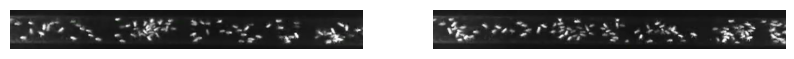

Imagehash
Images are different
0.46
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly001.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/Copy of fly030.jpg')


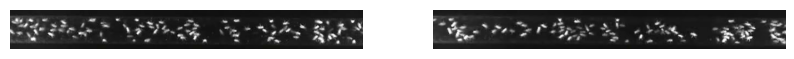

Imagehash
Images are different
0.45
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee068.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee062.jpg')


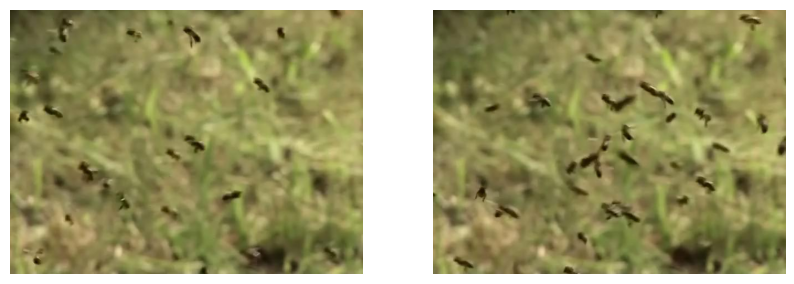

Imagehash
Images are different
0.8
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee062 (1).jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee039.jpg')


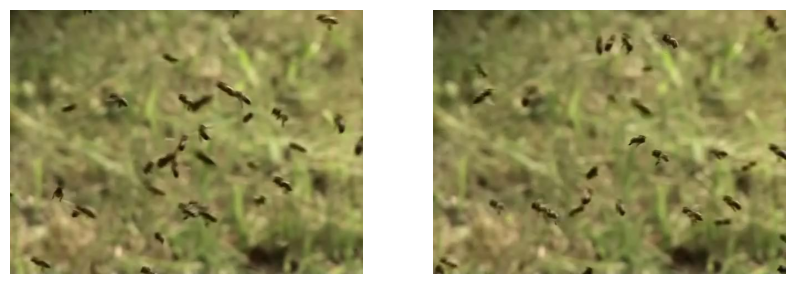

Imagehash
Images are different
0.78
ImageSSIM
Images are different


In [48]:
for element in cant_grab_list:
    print(element)
    image1 = Image.open(element[0])
    image2 = Image.open(element[1])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1)
    axs[0].axis('off')
    axs[1].imshow(image2)
    axs[1].axis('off')
    plt.show()
    result = compare_images_imghash(element[0], element[1])
    print("Imagehash")
    print('Images are the same' if result else 'Images are different')
    result = compare_images_ssim(element[0], element[1])
    print("ImageSSIM")
    print('Images are the same' if result else 'Images are different')

Change Threshold Of SSIM Algorithm

('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fish019.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fly028.jpg')


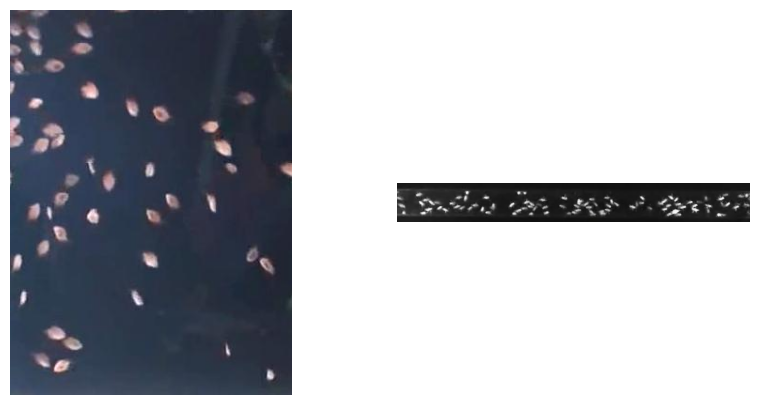

Imagehash
Images are different
0.33
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fish059.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fish033.jpg')


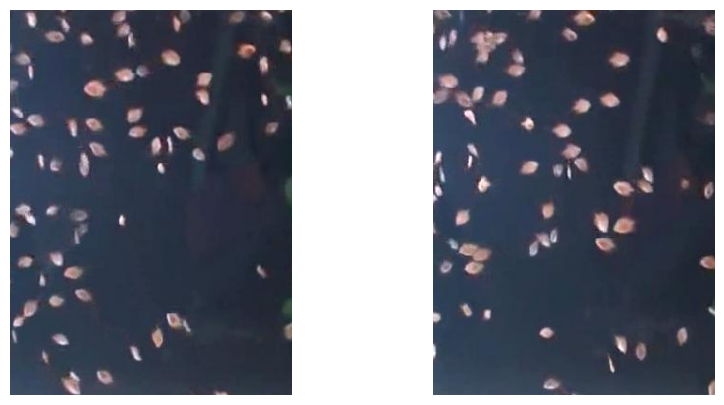

Imagehash
Images are different
0.53
ImageSSIM
Images are the same
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fly016.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fish027.jpg')


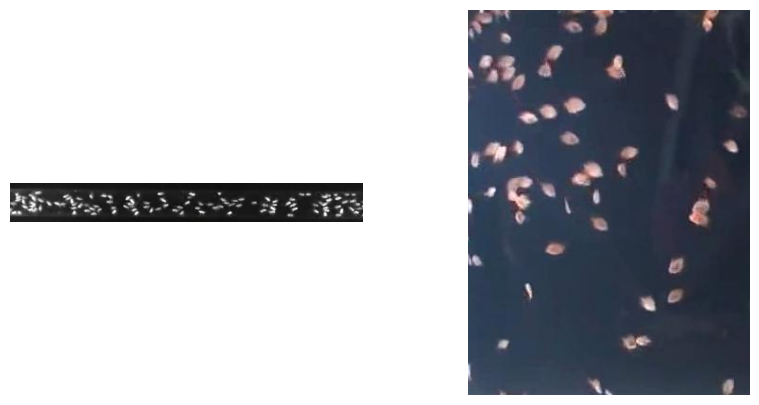

Imagehash
Images are different
0.3
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fish049.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/honeybee014.jpg')


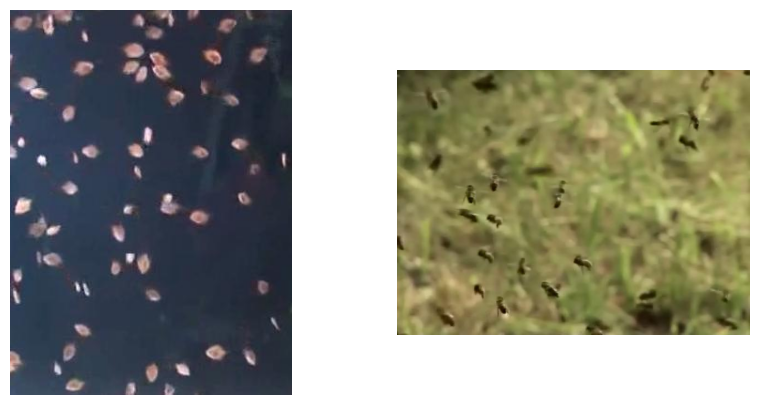

Imagehash
Images are different
0.2
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/seagull001.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/honeybee061.jpg')


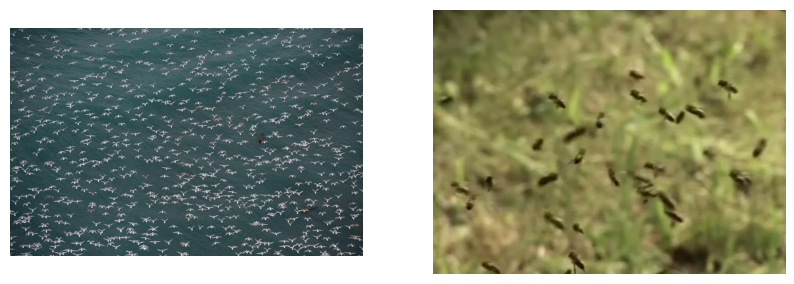

Imagehash
Images are different
0.08
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/honeybee067.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fly040.jpg')


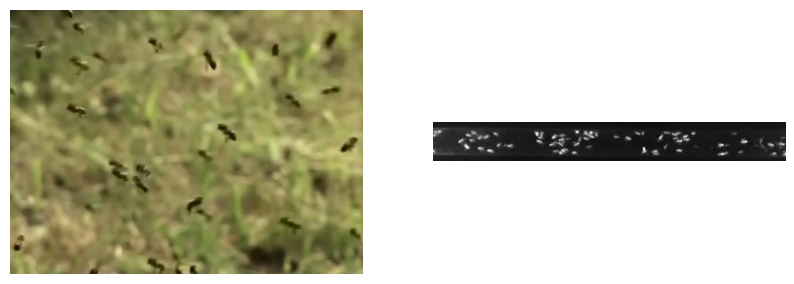

Imagehash
Images are different
0.11
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/honeybee052.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fly038.jpg')


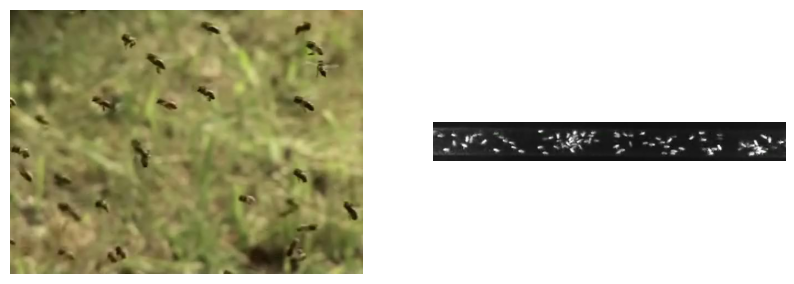

Imagehash
Images are different
0.1
ImageSSIM
Images are different
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fly035.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can identify/fly001.jpg')


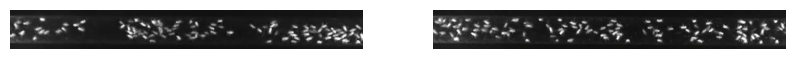

Imagehash
Images are different
0.46
ImageSSIM
Images are the same


In [50]:
for element in can_grab_list:
    print(element)
    image1 = Image.open(element[0])
    image2 = Image.open(element[1])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1)
    axs[0].axis('off')
    axs[1].imshow(image2)
    axs[1].axis('off')
    plt.show()
    result = compare_images_imghash(element[0], element[1])
    print("Imagehash")
    print('Images are the same' if result else 'Images are different')
    result = compare_images_ssim(element[0], element[1],threshold=0.4)
    print("ImageSSIM")
    print('Images are the same' if result else 'Images are different')

1st Test Again, After Changing Threshold Of SSIM Algorithm

('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly038.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly030.jpg')


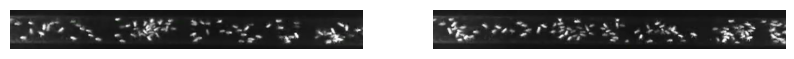

0.46
ImageSSIM
Images are the same
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/fly001.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/Copy of fly030.jpg')


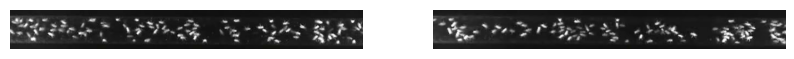

0.45
ImageSSIM
Images are the same
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee068.jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee062.jpg')


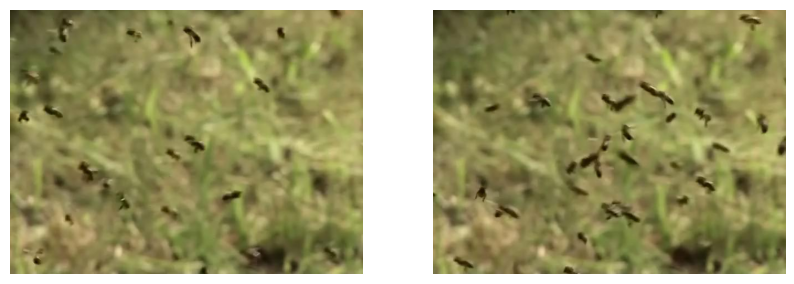

0.8
ImageSSIM
Images are the same
('/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee062 (1).jpg', '/content/drive/MyDrive/projects_data/Data_Privacy_Msc/test_images/can_t identify/honeybee039.jpg')


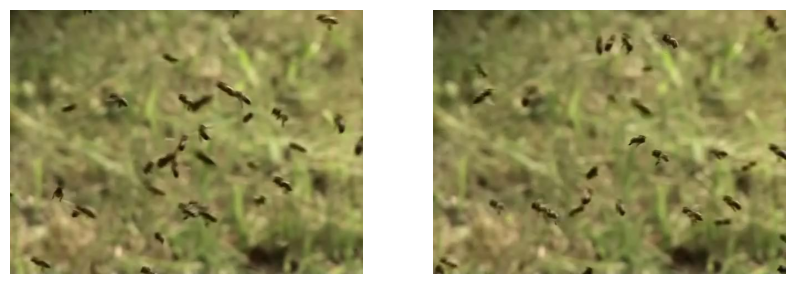

0.78
ImageSSIM
Images are the same


In [51]:
for element in cant_grab_list:
    print(element)
    image1 = Image.open(element[0])
    image2 = Image.open(element[1])
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1)
    axs[0].axis('off')
    axs[1].imshow(image2)
    axs[1].axis('off')
    plt.show()
    result = compare_images_ssim(element[0], element[1],threshold=0.4)
    print("ImageSSIM")
    print('Images are the same' if result else 'Images are different')